In [49]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import cpi


In [50]:
# importing movie budget data
budgets = pd.read_csv('data/tn.movie_budgets.csv.gz')
#Transforming budget and gross columns in integers
budgets.loc[:,["production_budget", 'domestic_gross', 'worldwide_gross']] = budgets.loc[:,["production_budget", 'domestic_gross', 'worldwide_gross']].applymap(lambda x: int(x.replace('$','').replace(",", "")))
budgets.loc[:,["production_budget", 'domestic_gross', 'worldwide_gross']] = budgets.loc[:,["production_budget", 'domestic_gross', 'worldwide_gross']].applymap(lambda x: x/1000000)
#creating profit columns to see the return on budget investment for each movie
budgets["profit_worldwide"] = budgets["worldwide_gross"] - budgets["production_budget"]
budgets["profit_domestic"] = budgets["domestic_gross"] - budgets["production_budget"]
budgets["profit_international"] = (budgets["worldwide_gross"] - budgets["domestic_gross"]) - budgets["production_budget"]
#Transforming release_date column to datetime data
budgets.release_date = pd.to_datetime(budgets.release_date)
#Creating Columns for Day, Month and Year of release
budgets['Month'] = budgets.release_date.dt.month
budgets["Year"] = budgets.release_date.dt.year
budgets["Day"] = budgets.release_date.dt.dayofweek
Day = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday" 
}
budgets["Day"] = budgets["Day"].map(Day)
#Adjusting worldwide profit and production budget for inflation
budgets["adjusted_profit_ww"] = budgets.apply(lambda x: cpi.inflate(x["profit_worldwide"], x["Year"]), axis = 1)
budgets["adjusted_budget"] = budgets.apply(lambda x: cpi.inflate(x["production_budget"], x["Year"]), axis = 1)
#Using inflation ajusted data to find the Return on Investment for each row
budgets["ROI"] = (budgets["adjusted_profit_ww"]/ budgets["adjusted_budget"]) *100


In [51]:
#importing basics data from imdb database
conn = sqlite3.connect('data/im2.db')
cursor_obj = conn.cursor()

basics = pd.read_sql("""
SELECT*
FROM movie_basics;

""", conn)

basics.drop(columns =["original_title", "movie_id", "start_year"], inplace = True)
basics = basics.rename(columns = {"primary_title": "movie"})

In [52]:
#Looing at value counts for each movie title
basics['movie'].value_counts()

Home                                   24
The Return                             20
Broken                                 20
Alone                                  16
Homecoming                             16
                                       ..
Same River Twice                        1
Straight Outta Compton                  1
Hung Ali                                1
Dream Journey 5: Legendary Treasure     1
Play the Film                           1
Name: movie, Length: 136071, dtype: int64

In [53]:
#merging data and removing duplicate titles
basic_budget = pd.merge(budgets, basics, how="left", on = "movie")
basic_budget.drop_duplicates(subset = ['movie', 'Year'], inplace = True)

In [54]:
#Making Genres into a list
bb_cg = basic_budget.dropna(subset = ["genres"])
bb_cg.loc[: ,"genres"] = bb_cg.loc[: , "genres"].apply(lambda x: str(x).split(","))

/Users/nathanielgreen/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [55]:
#Looking at Value Counts for each genre combination. I noticed that there were not a lot of mystery movies that exist.
# pd.set_option('display.max_rows', None)
bb_cg["genres"].value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1709, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[Drama]                           194
[Documentary]                     100
[Comedy]                           85
[Comedy, Drama]                    73
[Adventure, Animation, Comedy]     67
                                 ... 
[Biography, Drama, Fantasy]         1
[Drama, Fantasy, Music]             1
[Animation, Sci-Fi]                 1
[Adventure, Horror, Sci-Fi]         1
[Documentary, Western]              1
Name: genres, Length: 293, dtype: int64

In [56]:
#Exploding genre lists in order to separate the groups of data
explode = bb_cg.explode("genres")

In [57]:
#Grouping genres similar genres. Here I am grouping action and adventure and music and musical.
explode["genres"].replace("Action", "Action/Adventure", inplace = True)
explode["genres"].replace("Adventure", "Action/Adventure", inplace = True)
explode["genres"].replace("Music", "Musical", inplace = True)
#dropping low genre counts. I dropped genres that had 10 or fewer movies per genre in order to work with a large enough
#genre data sets
explode["genres"].replace("News", np.nan, inplace = True)
explode["genres"].replace("Reality-TV", np.nan, inplace = True)
explode["genres"].replace("Sport", np.nan, inplace = True)
explode.dropna(subset = ["genres"], inplace =True)

Drama               1146
Action/Adventure     986
Comedy               665
Thriller             392
Crime                311
Horror               288
Romance              267
Documentary          189
Biography            179
Sci-Fi               176
Mystery              174
Fantasy              154
Family               135
Animation            122
Musical               84
History               63
War                   31
Western               16
Name: genres, dtype: int64

In [58]:
#Reassigning Avatar to Action/Adventure because Avatar is not a Horror film and would skew my Horror data
explode.at[0,"genres"] = "Action/Adventure"

In [127]:
#Round 2 of drupping duplicate movies
explode.drop_duplicates(subset = ['movie', 'Year', "genres"], inplace = True)

In [128]:
#Looking at value counts per genre. Now there are no duplicates and ten or more movies per genre.
explode["genres"].value_counts()

Drama               1146
Action/Adventure     763
Comedy               665
Thriller             392
Crime                311
Horror               287
Romance              267
Documentary          189
Biography            179
Sci-Fi               176
Mystery              174
Fantasy              154
Family               135
Animation            122
Musical               82
History               63
War                   31
Western               16
Name: genres, dtype: int64

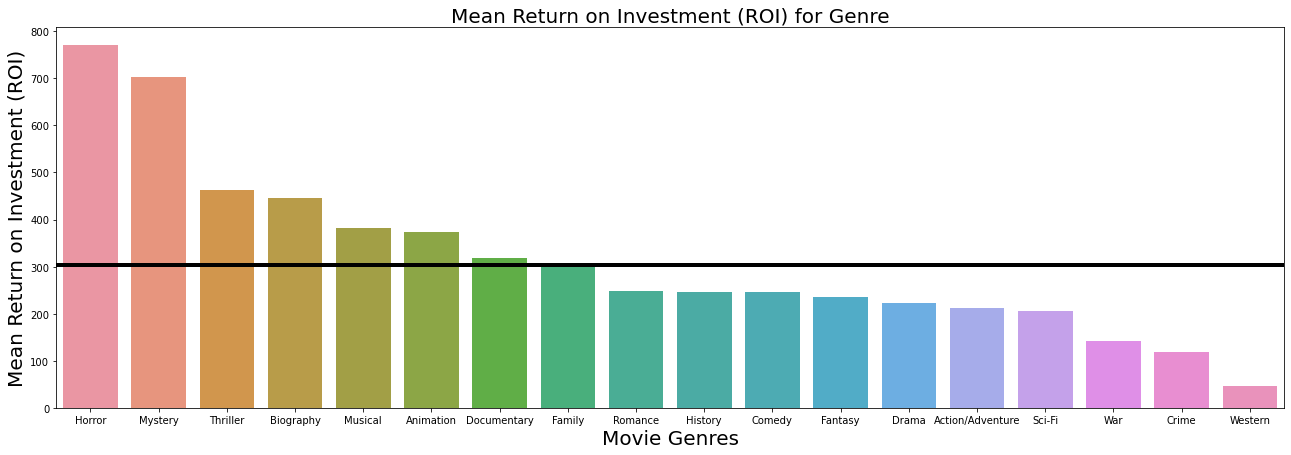

In [62]:
#Mean ROI per genre bar chart. Horror has the highest ROI but I suspect this data is skewed to the right.

genre_mean_df = explode.groupby('genres').mean().sort_values(by = 'ROI', ascending = False)

fig, ax = plt.subplots(figsize = (22,7))

z = sns.barplot(x = genre_mean_df.index, y = genre_mean_df['ROI'])
z.axhline(explode["ROI"].mean(), linewidth=4, color = "black")
plt.xlabel("Movie Genres", fontsize = 20)
plt.ylabel('Mean Return on Investment (ROI)', fontsize = 20)
plt.title("Mean Return on Investment (ROI) for Genre", fontsize = 20) 

plt.show()


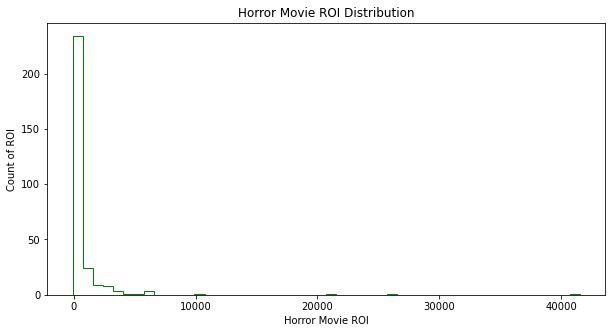

In [129]:
#Looking at the distributioin of Horror ROI through a histogram. We can see that this distribution has outliers
#and is skewed to the right, which is increasing the mean

horror = explode.loc[(explode["genres"] == "Horror"), 'ROI']

count = horror.count()

fig, ax = plt.subplots(figsize = (10,5))
ax.hist(horror, bins = 50, histtype = 'step', color = 'green')
ax.set_xlabel('Horror Movie ROI')
ax.set_ylabel('Count of ROI' )
ax.set_title('Horror Movie ROI Distribution')

plt.show()

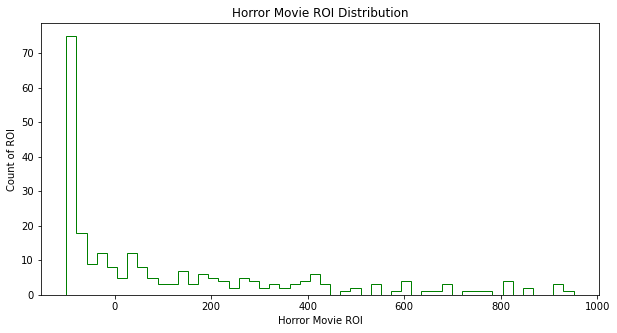

In [130]:
#Looking at the distributioin of Horror ROI less than 1,000% through a histogram to get a closer look at the
#majority of horror movie ROI

horror = explode.loc[(explode["genres"] == "Horror") & (explode["ROI"] < 1000), 'ROI']

count = horror.count()

fig, ax = plt.subplots(figsize = (10,5))
ax.hist(horror, bins = 50, histtype = 'step', color = 'green')
ax.set_xlabel('Horror Movie ROI')
ax.set_ylabel('Count of ROI' )
ax.set_title('Horror Movie ROI Distribution')

plt.show()

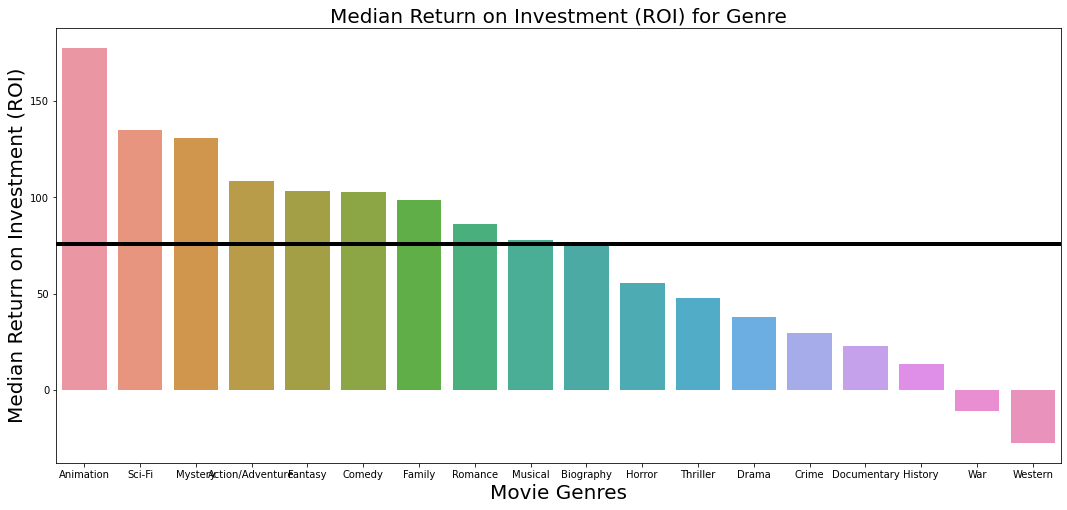

In [63]:
#Median ROI per genre bar chart shows a more accurate distribution of ROIs per Genre
genre_med_df = explode.groupby('genres').median().sort_values(by = 'ROI', ascending = False)

fig, ax = plt.subplots(figsize = (18,8))

z = sns.barplot(x = genre_med_df.index, y = genre_med_df['ROI'])
z.axhline(explode["ROI"].median(), linewidth=4, color = "black")
plt.xlabel("Movie Genres", fontsize = 20)
plt.ylabel('Median Return on Investment (ROI)', fontsize = 20)
plt.title("Median Return on Investment (ROI) for Genre", fontsize = 20) 

plt.show()

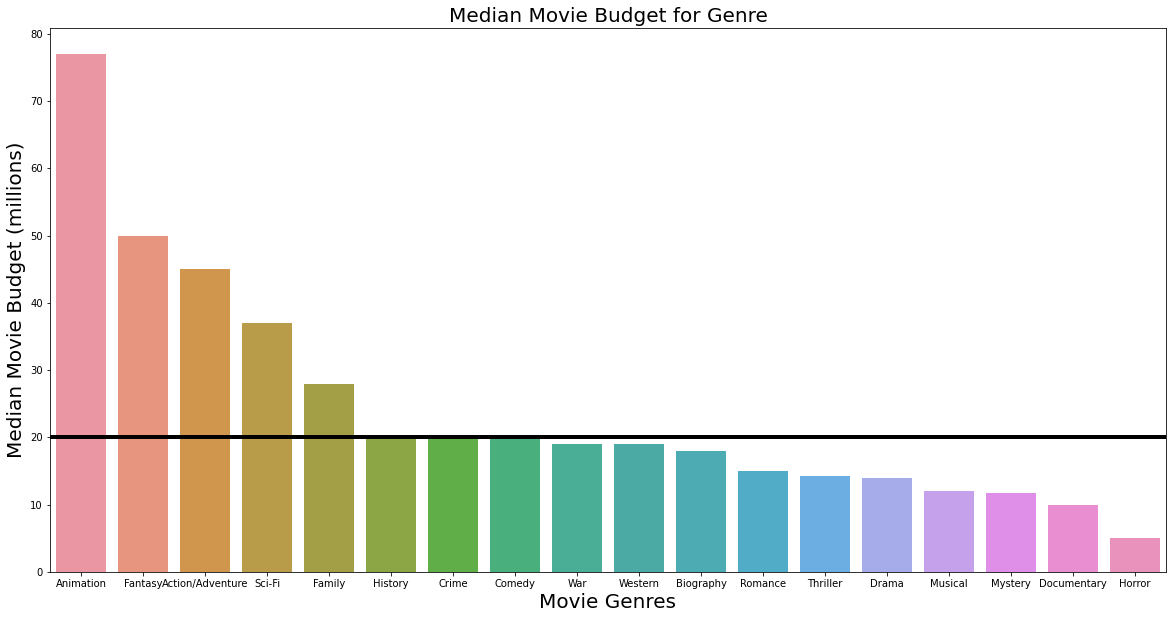

In [64]:
#My graph of median movie budgets per genre shows that horror has the smallest budget
genre_budget_df = explode.groupby('genres').median().sort_values(by = "production_budget", ascending = False)

fig, ax = plt.subplots(figsize = (20,10))
z = sns.barplot(x = genre_budget_df.index, y = genre_budget_df['production_budget'])
z.axhline(explode["production_budget"].median(), linewidth=4, color = "black")
plt.xlabel("Movie Genres", fontsize = 20)
plt.ylabel('Median Movie Budget (millions)', fontsize = 20)
plt.title("Median Movie Budget for Genre", fontsize = 20) 

plt.show()



<AxesSubplot:ylabel='Frequency'>

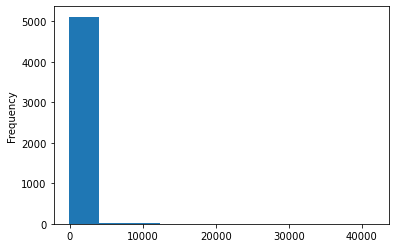

In [66]:
#In order to define "cult classic" I defined high ROI as being in the top 75% of movie ROIs
high_ROI = explode["ROI"].quantile(q = 0.75)
explode["ROI"].plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

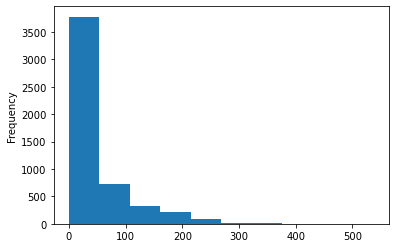

In [67]:
#In order to define "cult classic" I defined low budget as being in the bottom 25% of movie budgets
low_budget = explode["adjusted_budget"].quantile(q = 0.25)
explode["adjusted_budget"].plot(kind='hist')

In [131]:
#Here I sorted my data frame for cult classic films and created a new data frame called b_movie_counts
#In this new data frame I calculated the percent chance of a movie becoming a cult classic
b_movie_df = explode.loc[(explode["ROI"] > high_ROI) & (explode["adjusted_budget"] < low_budget), "genres"]
b_movie_counts = b_movie_df.value_counts().reset_index()

b_movie_counts.rename(columns = {"index":"Genre", "genres":"Cult_Classic_Movies"}, inplace = True)
b_movie_counts['Number_of_Movies'] = [1146, 287, 665, 392, 174, 267, 987, 176, 189, 179, 311, 154, 84, 135, 63]
b_movie_counts["Cult_Classic_Percentage"] = b_movie_counts["Cult_Classic_Movies"]/ b_movie_counts["Number_of_Movies"]*100

Animation_Data = {"Genre": "Animation", "Cult_Classic_Movies": 0, "Number_of_Movies": 122, "Cult_Classic_Percentage": 0.0}
b_movie_counts = b_movie_counts.append(Animation_Data, ignore_index = True)



In [132]:
#Here I cut down my cult classic movie dataframe to only the genres I cared about, which include Horror, Thrillers,
#Action/Adventure and Animation
b_movie_counts
b_movies_top = b_movie_counts.loc[(b_movie_counts["Genre"] == "Horror")|(b_movie_counts["Genre"] == "Thriller")|(b_movie_counts["Genre"] == "Action/Adventure")| (b_movie_counts["Genre"] == "Animation")].reset_index()
b_movies_top.drop(columns = ["index"], inplace = True)
b_movies_top.sort_values(by = 'Cult_Classic_Percentage', ascending = False)


,Genre,Cult_Classic_Movies,Number_of_Movies,Cult_Classic_Percentage
0,Horror,44,287,15.331010
1,Thriller,29,392,7.397959
2,Action/Adventure,14,987,1.418440
3,Animation,0,122,0.000000


Text(0.5, 1.0, 'Chance of Cult Classic by Genre')

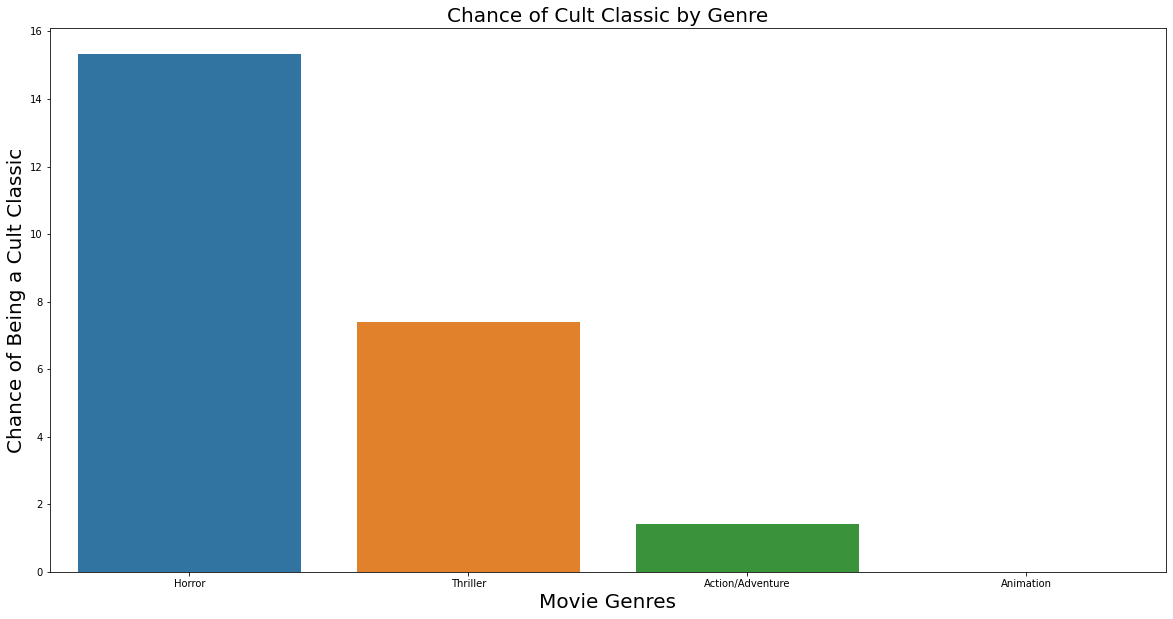

In [74]:
#Below I created a bar graph of the percent change that a genre will produce a cult classic
fig, ax = plt.subplots(figsize = (20,10))
ax = sns.barplot(x = 'Genre', y = 'Cult_Classic_Percentage', data= b_movies_top)
plt.title("Percent of Movies that Become Cult Classics by Genre");
plt.xlabel("Movie Genres", fontsize = 20)
plt.ylabel('Chance of Being a Cult Classic', fontsize = 20)
plt.title("Chance of Cult Classic by Genre", fontsize = 20)

In [75]:
#Here I created a dataframe column called Market Quarter which categorizes a movie by the quarter it was released
explode["Market Quarter"] = explode["Month"].apply(lambda x: "Q1" if x<4 else("Q2" if 3<x<6 else("Q3" if 5<x<9 else "Q4")))

Text(0.5, 1.0, 'Movies Release Per Quarter')

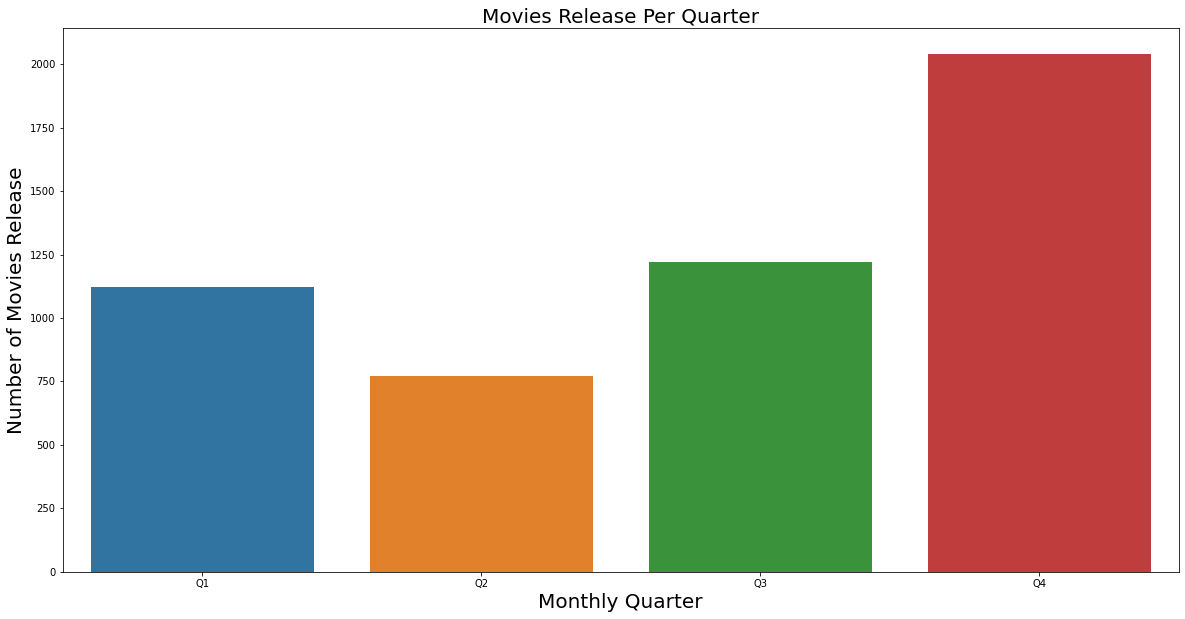

In [59]:
#Here I created a bar chart of the number of movies released per quarter
quarter_count = explode.groupby('Market Quarter').count().reset_index()
fig, ax = plt.subplots(figsize = (20,10))
sns.barplot(x = 'Market Quarter', y = 'id', data= quarter_count)
plt.ylabel('Number of Movies Release', fontsize = 20)
plt.xlabel('Monthly Quarter', fontsize = 20)
plt.title("Movies Release Per Quarter", fontsize = 20)

Text(0.5, 1.0, 'Movies Release Per Quarter')

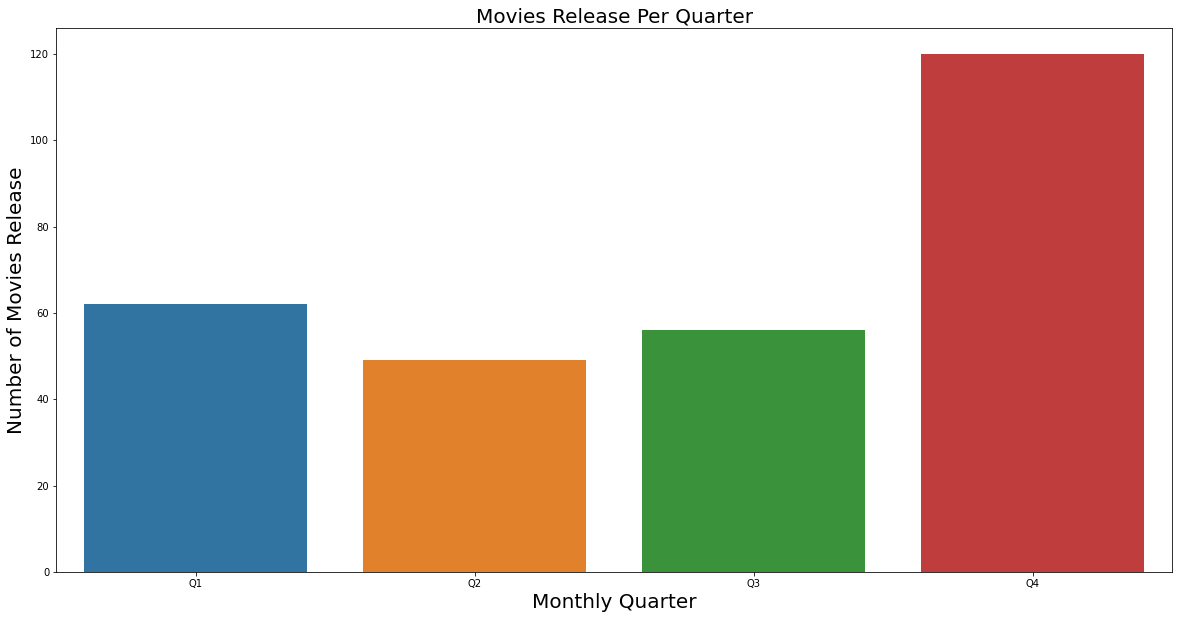

In [77]:
#Below I created a bar graph of the number of horror movies released per quarter
quarter_count_horror = explode.loc[explode["genres"] == "Horror"].groupby('Market Quarter').count().reset_index()
fig, ax = plt.subplots(figsize = (20,10))
sns.barplot(x = 'Market Quarter', y = 'id', data= quarter_count_horror)
plt.ylabel('Number of Movies Release', fontsize = 20)
plt.xlabel('Monthly Quarter', fontsize = 20)
plt.title("Movies Release Per Quarter", fontsize = 20)

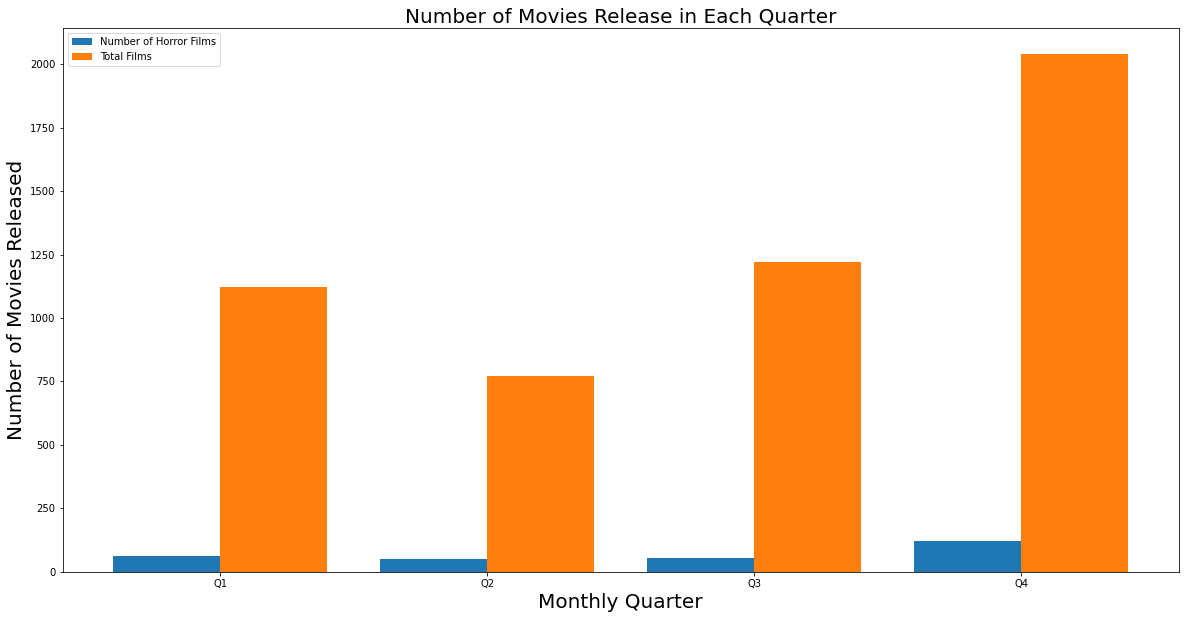

In [78]:
#Here I created a side by side bar graph showing the number of horror movies and total movies released per quarter

quarter_count_horror = explode.loc[explode["genres"] == "Horror"].groupby('Market Quarter').count().reset_index()
Horror_count = quarter_count_horror[["Market Quarter", "id"]]
Horror_count = Horror_count.rename(columns = {"id": "Horror Movie Count"})

quarter_count = explode.groupby('Market Quarter').count().reset_index()
movie_count = quarter_count[["Market Quarter", "id"]]
movie_count = movie_count.rename(columns = {"id": "Total Movie Count"})

all_counts = pd.merge(movie_count, Horror_count, how = "left", on = "Market Quarter")


Horror_counts = Horror_count["Horror Movie Count"]
All_count = all_counts["Total Movie Count"]
fig, ax = plt.subplots(figsize = (20,10))
X_axis = np.arange(len(All_count))
plt.bar(X_axis - 0.2, Horror_counts, 0.4, label = 'Number of Horror Films')
plt.bar(X_axis + 0.2, All_count, 0.4, label = 'Total Films')
plt.xticks(X_axis, ["Q1", "Q2", "Q3", "Q4"])
plt.legend()
plt.ylabel('Number of Movies Released', fontsize = 20)
plt.xlabel('Monthly Quarter', fontsize = 20)
plt.title("Number of Movies Release in Each Quarter", fontsize = 20);

/Users/nathanielgreen/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


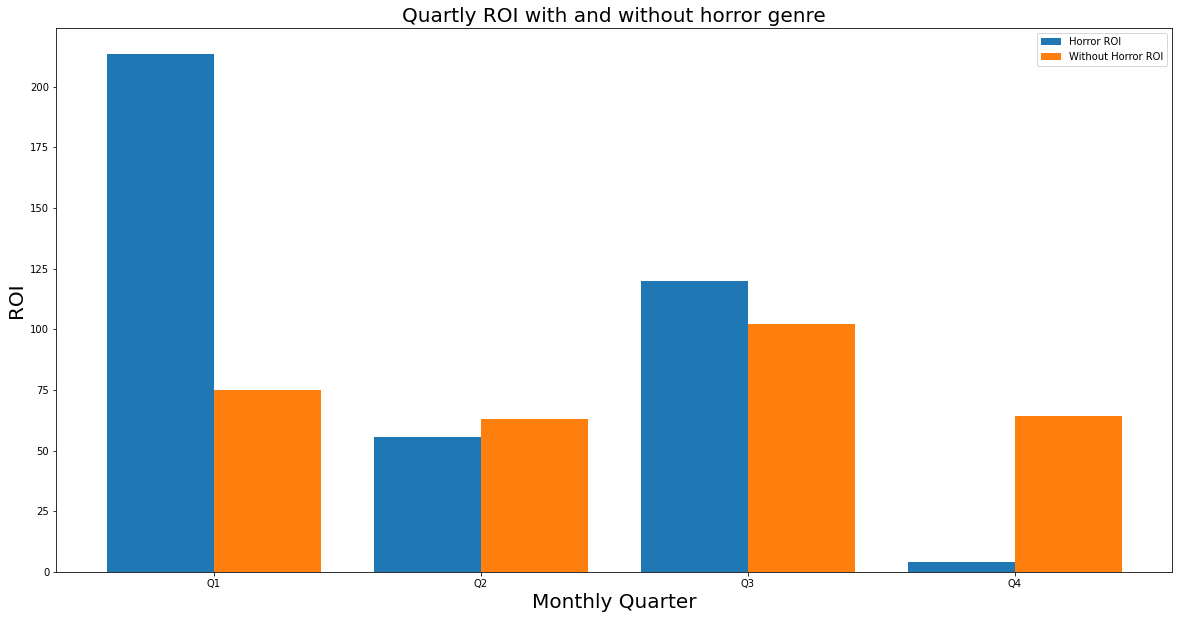

In [79]:
#Here is a side by side bar graph showing quarterly ROI for horror movies and non horror movies
quarter_horror_roi = explode[explode['genres'] =='Horror'].groupby('Market Quarter').median().reset_index()
Horror_data = quarter_horror_roi[["Market Quarter", "ROI"]]
Horror_data.rename(columns = {"ROI": "Horror ROI"}, inplace = True)

quarter_ROI = explode[explode['genres']!='Horror'].groupby('Market Quarter').median().reset_index()
No_Horror_Data = quarter_ROI[["Market Quarter", "ROI"]]
No_Horror_Data.rename(columns = {"ROI": "No Horror ROI"}, inplace = True)

quarter_roi_data = pd.merge(Horror_data, No_Horror_Data, how = "left", on = "Market Quarter" )

Horror_ROI = quarter_roi_data["Horror ROI"]
NO_Horror_ROI = quarter_roi_data["No Horror ROI"]
fig, ax = plt.subplots(figsize = (20,10))
X_axis = np.arange(len(NO_Horror_ROI))
plt.bar(X_axis - 0.2, Horror_ROI, 0.4, label = 'Horror ROI')
plt.bar(X_axis + 0.2, NO_Horror_ROI, 0.4, label = 'Without Horror ROI')
plt.xticks(X_axis, ["Q1", "Q2", "Q3", "Q4"])
plt.legend()
plt.ylabel('ROI', fontsize = 20)
plt.xlabel('Monthly Quarter', fontsize = 20)
plt.title("Quartly ROI with and without horror genre", fontsize = 20);


In [80]:
#connecting to my IMDB data base
conn = sqlite3.connect('data/im2.db')
cursor_obj = conn.cursor()

In [81]:
#Viewing IMDB database tables
%%bash

sqlite3 data/im2.db

.tables

directors      movie_akas     movie_ratings  principals   
known_for      movie_basics   persons        writers      


In [82]:
#using SQL to query the basics table
basics = pd.read_sql("""
SELECT*
FROM movie_basics;

""", conn)
basics

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,None


In [83]:
#using SQL to query the persons table
persons = pd.read_sql("""
SELECT*
FROM persons;

""", conn)

persons


,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator"
...,...,...,...,...,...
606643,nm9990381,Susan Grobes,NaN,NaN,actress
606644,nm9990690,Joo Yeon So,NaN,NaN,actress
606645,nm9991320,Madeline Smith,NaN,NaN,actress
606646,nm9991786,Michelle Modigliani,NaN,NaN,producer


In [133]:
#using SQL to query the known_for table
known_for = pd.read_sql("""
SELECT*
FROM known_for;

""", conn)

known_for

,person_id,movie_id
0,nm0061671,tt0837562
1,nm0061671,tt2398241
2,nm0061671,tt0844471
3,nm0061671,tt0118553
4,nm0061865,tt0896534
...,...,...
1638255,nm9990690,tt9090932
1638256,nm9990690,tt8737130
1638257,nm9991320,tt8734436
1638258,nm9991320,tt9615610


In [114]:
#Merging the known_for and persons talbes into a person_merge table
person_merge = pd.merge(known_for, persons, how="inner", on = "person_id")
person_merge 

,person_id,movie_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,tt0837562,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061671,tt2398241,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
2,nm0061671,tt0844471,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
3,nm0061671,tt0118553,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
4,nm0061865,tt0896534,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
...,...,...,...,...,...,...
1638255,nm9990690,tt9090932,Joo Yeon So,NaN,NaN,actress
1638256,nm9990690,tt8737130,Joo Yeon So,NaN,NaN,actress
1638257,nm9991320,tt8734436,Madeline Smith,NaN,NaN,actress
1638258,nm9991320,tt9615610,Madeline Smith,NaN,NaN,actress


In [115]:
#merging my new person_merge table to the basics table in order to get genres
#Also made the primary_profession column into a list of professions
persons_movies = pd.merge(person_merge, basics, how="inner", on = "movie_id")
persons_movies = persons_movies.drop(columns = ["birth_year", "death_year", "original_title"])
persons_movies.dropna(subset = ["primary_profession"], inplace = True)
persons_movies["primary_profession"] = persons_movies["primary_profession"].apply(lambda x: str(x).split(","))
persons_movies

,person_id,movie_id,primary_name,primary_profession,primary_title,start_year,runtime_minutes,genres
0,nm0061671,tt0837562,Mary Ellen Bauder,"[miscellaneous, production_manager, producer]",Hotel Transylvania,2012,91.0,"Animation,Comedy,Family"
1,nm0757932,tt0837562,James T. Sale,"[music_department, composer, actor]",Hotel Transylvania,2012,91.0,"Animation,Comedy,Family"
2,nm0123741,tt0837562,CeeLo Green,"[soundtrack, actor, composer]",Hotel Transylvania,2012,91.0,"Animation,Comedy,Family"
3,nm0001484,tt0837562,Jon Lovitz,"[actor, soundtrack, writer]",Hotel Transylvania,2012,91.0,"Animation,Comedy,Family"
4,nm0244110,tt0837562,Todd Durham,"[writer, director, producer]",Hotel Transylvania,2012,91.0,"Animation,Comedy,Family"
...,...,...,...,...,...,...,...,...
791001,nm9548101,tt7878430,W Lee Wray,"[director, writer, producer]",The Charger We Not Me,2015,78.0,Documentary
791002,nm9687040,tt8118944,Pablo Dominguez,[actor],My Darling Son,2018,61.0,Documentary
791003,nm9734903,tt8208268,Thakkali Srinivasan,"[director, actor]",Aduthathu,2011,NaN,Thriller
791004,nm9909687,tt8561352,Bastien Larue,"[director, writer, cinematographer]",Les officiants,2016,52.0,Documentary


In [116]:
#Making the genres into a list of genres
persons_movies["genres"] = persons_movies["genres"].apply(lambda x: str(x).split(","))


In [117]:
#renamed the column primary_title to movies
persons_movies.rename(columns = {"primary_title": "movie"}, inplace = True)


In [118]:
#in order to get budget data, I merged persons_movies to my cleaned budget data
final_data = pd.merge(persons_movies, budgets, how="inner", on = "movie")
final_data_2 = final_data.drop(columns = ["id", "person_id", "movie_id", "runtime_minutes", "release_date", "worldwide_gross", "profit_worldwide", "profit_domestic", "profit_international", "production_budget", "domestic_gross"])

In [119]:
#exploding my genre data in my talbe
final_data_3 = final_data_2.explode("genres")

In [120]:
#sorting my data for directors that had three or more films
horror_movies = final_data_3.loc[final_data_3["genres"] == "Horror"]
is_multi = horror_movies["primary_name"].value_counts() > 2
filtered_horror = horror_movies[horror_movies["primary_name"].isin(is_multi[is_multi].index)]
filtered_horror

,primary_name,primary_profession,movie,start_year,genres,Month,Year,Day,adjusted_profit_ww,adjusted_budget,ROI
1489,Sarah Mulholland,"[camera_department, cinematographer, producer]",The Thing,2011,Horror,10,2011,Friday,-12.560663,45.776233,-27.439268
3590,Jeff Lam,"[actor, producer, casting_director]",Home,2016,Horror,3,2015,Friday,292.669935,148.622673,196.921458
3591,Jeff Lam,"[actor, producer, casting_director]",Home,2016,Horror,6,2009,Friday,-15.156546,15.156546,-100.000000
3592,Jeff Lam,"[actor, producer, casting_director]",Home,2016,Horror,4,2009,Thursday,55.944288,0.631523,8858.633600
3593,Brian Roberts,"[producer, casting_department, casting_director]",Home,2016,Horror,3,2015,Friday,292.669935,148.622673,196.921458
...,...,...,...,...,...,...,...,...,...,...,...
54528,Jared Banta,"[music_department, composer]",Pet Sematary,2019,Horror,4,2019,Friday,93.802069,22.257830,421.434029
54529,Jared Banta,"[music_department, composer]",Pet Sematary,2019,Horror,4,1989,Friday,100.453778,25.130282,399.731991
55326,Gregory Plotkin,"[editorial_department, editor, producer]",Hell Fest,2018,Horror,9,2018,Friday,13.617434,5.935060,229.440564
55999,Morgan Peter Brown,"[actor, producer, miscellaneous]",Absentia,2011,Horror,12,2011,Saturday,-0.074019,0.084325,-87.778571


In [125]:
#Looking at movie professionals with hightest ROI
filtered_horror.groupby("primary_name").median().sort_values(by = "ROI", ascending = False).head(50)

,start_year,Month,Year,adjusted_profit_ww,adjusted_budget,ROI
primary_name,,,,,,
Gerard DiNardi,2013.0,6.0,2013.0,102.669572,3.540641,2942.219367
Keith Blomberg,2013.0,6.0,2013.0,99.996924,3.540641,2824.260233
Sam Schweikert,2012.0,10.0,2012.0,162.654692,5.901069,2756.359840
Matteo Saradini,2018.0,2.0,2018.0,98.875226,5.527293,2617.924114
Timothy Alverson,2018.0,10.0,2007.0,264.272735,10.791017,2449.006670
Kyle Perritt,2018.0,10.0,2007.0,264.272735,10.791017,2449.006670
Henry Snyder,2018.0,10.0,2007.0,264.272735,10.791017,2449.006670
Jake Kuykendall,2018.0,10.0,2007.0,264.272735,10.791017,2449.006670
James Jude Courtney,2018.0,10.0,2007.0,264.272735,10.791017,2449.006670


In [122]:
#Sorting data fram for only directors
director_horror = pd.DataFrame(columns = filtered_horror.columns)
for idx,value in enumerate(filtered_horror['primary_profession']):
    if 'director' in value:
        a = filtered_horror.iloc[idx,:]
        director_horror = director_horror.append(a, ignore_index = True)
     

In [123]:
#sorting the data table of only directors by ROI
director_horror.groupby("primary_name").median().sort_values(by = "ROI", ascending = False).head(50)

,adjusted_profit_ww,adjusted_budget,ROI
primary_name,,,
Matteo Saradini,98.875226,5.527293,2617.924114
Aaron Christian Paderewski,264.272735,10.791017,2449.006670
Justin Moskos,264.272735,10.791017,2449.006670
David Gordon Green,264.272735,10.791017,2449.006670
Henry Snyder,264.272735,10.791017,2449.006670
Malek Akkad,264.272735,10.791017,2449.006670
Amman Abbasi,264.272735,10.791017,2449.006670
Jamie Lee Curtis,264.272735,10.791017,2449.006670
Gary Dauberman,321.008432,16.581878,1935.899100


In [124]:
#sorting the data table of only directors by adjusted profit
director_horror.groupby("primary_name").median().sort_values(by = "adjusted_profit_ww", ascending = False).head(50)

,adjusted_profit_ww,adjusted_budget,ROI
primary_name,,,
Gary Dauberman,321.008432,16.581878,1935.899100
Hiroyuki Kobayashi,296.218651,71.453090,414.563809
Aaron Christian Paderewski,264.272735,10.791017,2449.006670
David Gordon Green,264.272735,10.791017,2449.006670
Henry Snyder,264.272735,10.791017,2449.006670
Amman Abbasi,264.272735,10.791017,2449.006670
Jamie Lee Curtis,264.272735,10.791017,2449.006670
Justin Moskos,264.272735,10.791017,2449.006670
Malek Akkad,264.272735,10.791017,2449.006670
